In [3]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import torch.optim
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

### Create toy data

In [45]:
numClasses = 4
numFeatures = 2

# create data
xBlob, yBlob = make_blobs(n_samples=1000, n_features=numFeatures ,centers=numClasses,
                          cluster_std=1.0)

# convert to tensor
xBlob, yBlob = torch.tensor(xBlob, dtype=torch.float), torch.tensor(yBlob, dtype=torch.float)

# split into training/test
xBlobTrain, xBlobTest, yBlobTrain, yBlobTest = train_test_split(xBlob, yBlob, test_size=0.2)



In [43]:
xBlobTrain.shape, yBlobTrain.shape

(torch.Size([800, 2]), torch.Size([800]))

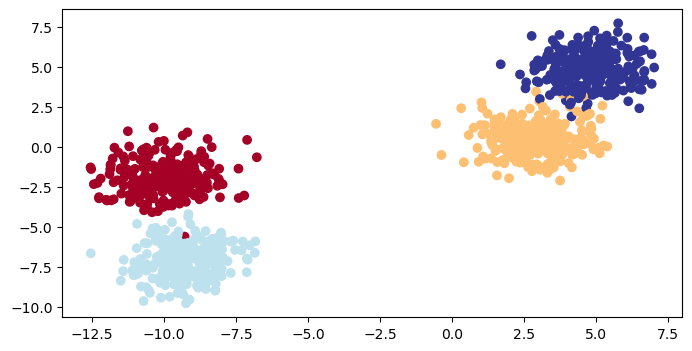

In [46]:
# visualize the data

plt.figure(figsize=(8,4))
plt.scatter(xBlob[:, 0], xBlob[:, 1], c=yBlob, cmap=plt.cm.RdYlBu)

### Build the model

In [16]:
dev = "cuda" if torch.cuda.is_available() else "cpu" 

In [20]:
class MultiClassBlob(nn.Module):
    def __init__(self, inputFeatures, outputFeatures, hiddenUnits=8):
        super().__init__()
        
        self.linearLayers = nn.Sequential(
            nn.Linear(in_features=inputFeatures, out_features=hiddenUnits),
            nn.ReLU(),
            nn.Linear(in_features=hiddenUnits, out_features=hiddenUnits),
            nn.ReLU(),
            nn.Linear(in_features=hiddenUnits, out_features=outputFeatures)
        )

    def forward(self, x):
        return self.linearLayers(x)

In [22]:
# create instance of model
blobModel = MultiClassBlob(2, 4, 8).to(dev)
blobModel

MultiClassBlob(
  (linearLayers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### Train the model

In [23]:
# create loss function
lossFn = torch.nn.CrossEntropyLoss()

# create optimizer
optimizer = torch.optim.SGD(params=blobModel.parameters(), lr=0.01)

In [40]:
# investigate model outputs 

with torch.inference_mode():
    yPred = blobModel(xBlobTrain)

yPredProbs = torch.softmax(yPred, dim=1)
yPredLabels = torch.vmap(lambda x: torch.argmax(x).type(torch.float))(yPredProbs)
yPredProbs[:10], yPredLabels[:10], yBlobTrain[:10]

AttributeError: 'Tensor' object has no attribute 'vmap'

In [52]:
epochs = 2001

## put on target device
xBlobTrain, xBlobTest = xBlobTrain.to(dev), xBlobTest.to(dev)
yBlobTrain, yBlobTest = yBlobTrain.to(dev), yBlobTest.to(dev)

for epoch in range(epochs):
    blobModel.train()

    yLogits = blobModel(xBlobTrain)
    yPredsTemp = torch.softmax(yLogits, dim=1)
    yPreds = torch.vmap(lambda x: torch.argmax(x).type(torch.long))(yPredsTemp)

    loss = lossFn(yLogits, yBlobTrain.type(torch.long))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # testing

    blobModel.eval()
    with torch.inference_mode():
        testLogits = blobModel(xBlobTest)
        testPredsTemp = torch.softmax(testLogits, dim=1)
        testPreds = torch.vmap(lambda x: torch.argmax(x).type(torch.long))(testPredsTemp)

        testLoss = lossFn (testLogits, yBlobTest.type(torch.long))

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss}, Test Loss: {testLoss}")


Epoch: 0, Loss: 0.06841098517179489, Test Loss: 0.1010160893201828
Epoch: 100, Loss: 0.066521055996418, Test Loss: 0.09950453042984009
Epoch: 200, Loss: 0.06480122357606888, Test Loss: 0.0980706587433815
Epoch: 300, Loss: 0.0632251650094986, Test Loss: 0.09676945954561234
Epoch: 400, Loss: 0.06177172809839249, Test Loss: 0.09554854035377502
Epoch: 500, Loss: 0.06042484939098358, Test Loss: 0.09440673142671585
Epoch: 600, Loss: 0.05916903167963028, Test Loss: 0.09333044290542603
Epoch: 700, Loss: 0.05799596756696701, Test Loss: 0.09229856729507446
Epoch: 800, Loss: 0.05689156427979469, Test Loss: 0.09132251888513565
Epoch: 900, Loss: 0.05584489926695824, Test Loss: 0.09042417258024216
Epoch: 1000, Loss: 0.0548565536737442, Test Loss: 0.08957532793283463
Epoch: 1100, Loss: 0.053922343999147415, Test Loss: 0.08875785768032074
Epoch: 1200, Loss: 0.053041838109493256, Test Loss: 0.08798708766698837
Epoch: 1300, Loss: 0.052207447588443756, Test Loss: 0.0872429758310318
Epoch: 1400, Loss: 0.0

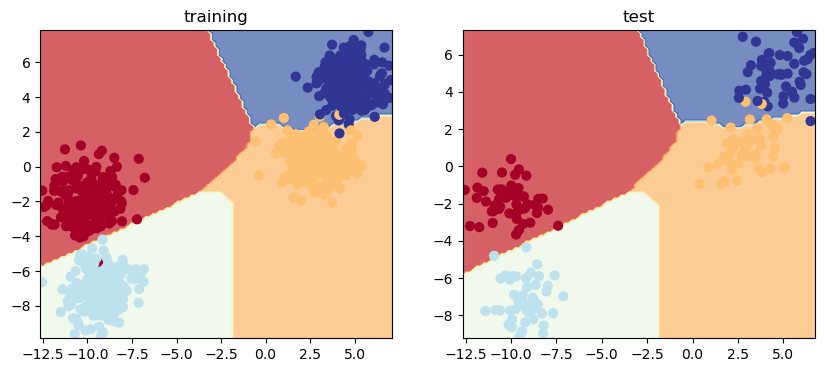

In [57]:
# visualize optimized model
from helpers import plot_decision_boundary



plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("training")
plot_decision_boundary(blobModel, xBlobTrain, yBlobTrain)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(blobModel, xBlobTest, yBlobTest)





In [61]:
# additional metrics 
from torchmetrics import Accuracy


with torch.inference_mode():
    yPred = blobModel(xBlobTest)

yPredProbs = torch.softmax(yPred, dim=1)
yPredLabels = torch.vmap(lambda x: torch.argmax(x).type(torch.long))(yPredProbs)

acc = Accuracy(task="multiclass", num_classes=4)

acc(yPredLabels, yBlobTest.type(torch.long))


tensor(0.9600)